In [8]:
import logging
import sys
from typing import List
import time
from datetime import datetime
from pathlib import Path
import json
import csv
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from langchain_openai import OpenAI
from config.settings import Settings
from config.logging_config import setup_logging
from models.embedding_service import EmbeddingService
from models.vector_store import MongoDBVectorStore
from core.rag_executor import RAGExecutor
from models.query_result import QueryResult
from strategies.basic_rag import BasicRAGStrategy
from strategies.multi_query_rag import MultiQueryRAGStrategy
from strategies.hypothetical_rag import HypotheticalRAGStrategy
from strategies.step_back_rag import StepBackRAGStrategy
from utils.logging_utils import LoggerUtils
from utils.metrics_utils import MetricsCalculator


setup_logging()
logger = logging.getLogger(__name__)

2025-01-17 17:49:31 - config.logging_config - INFO - Logging system initialized


In [4]:
def initialize_components(settings: Settings) -> RAGExecutor:
    """
    Initialize the embedding service, vector store, LLM, and RAG executor.

    Args:
        settings (Settings): Configuration settings.

    Returns:
        RAGExecutor: An instance of the RAGExecutor.
    """
    try:
        # Setup embedding service
        logger.info("Initializing embedding service...")
        embedding_service = EmbeddingService(
            api_key=settings.EMBEDDING_CONFIG["api_key"],
            base_url=settings.EMBEDDING_CONFIG["base_url"],
            model=settings.EMBEDDING_CONFIG["model"]
        )

        # Setup vector store
        logger.info("Initializing vector store...")
        vector_store = MongoDBVectorStore(
            mongodb_uri=settings.MONGODB_CONFIG["uri"],
            db_name=settings.MONGODB_CONFIG["db_name"],
            collection_name=settings.MONGODB_CONFIG["collection_name"],
            embedding_service=embedding_service
        )

        # Setup LLM with explicit model name
        logger.info("Initializing LLM...")
        llm = OpenAI(
            model_name=settings.LLM_CONFIG["model"],  
            temperature=settings.LLM_CONFIG["temperature"],
            max_tokens=settings.LLM_CONFIG["max_tokens"],
            api_key=settings.LLM_CONFIG["api_key"],
            base_url=settings.LLM_CONFIG["api_base"],
            top_p=settings.LLM_CONFIG["model_kwargs"].get("top_p", 1.0), 
            presence_penalty=settings.LLM_CONFIG["model_kwargs"].get("presence_penalty", 0.0),  
            frequency_penalty=settings.LLM_CONFIG["model_kwargs"].get("frequency_penalty", 0.0)  
        )

        # Initialize RAG executor
        logger.info("Initializing RAG executor...")
        executor = RAGExecutor(
            retriever=vector_store,
            embedding_service=embedding_service,
            llm=llm,
            config=settings.STRATEGY_CONFIGS
        )

        return executor

    except Exception as e:
        logger.error(f"Failed to initialize components: {str(e)}", 
                    extra={"error_type": type(e).__name__})
        raise


In [5]:
test_queries = [
    "I need storage solutions for a small bathroom",
]

# Load settings
settings = Settings()
logger.info("Loaded settings", extra={
    "base_dir": str(settings.BASE_DIR),
    "log_dir": str(settings.LOG_DIR),
    "results_dir": str(settings.RESULTS_DIR)
})

# Initialize components
executor = initialize_components(settings)


2025-01-17 17:48:34 - config.settings - INFO - Set default configuration
2025-01-17 17:48:34 - config.settings - INFO - Initialized settings
2025-01-17 17:48:34 - __main__ - INFO - Loaded settings
2025-01-17 17:48:34 - __main__ - INFO - Initializing embedding service...
2025-01-17 17:48:34 - models.embedding_service - INFO - Initialized embedding service
2025-01-17 17:48:34 - __main__ - INFO - Initializing vector store...
2025-01-17 17:48:35 - models.vector_store - INFO - Initialized MongoDB Vector Store
2025-01-17 17:48:35 - __main__ - INFO - Initializing LLM...
2025-01-17 17:48:35 - __main__ - INFO - Initializing RAG executor...
2025-01-17 17:48:35 - strategies.base_strategy - INFO - Initialized BasicRAGStrategy
2025-01-17 17:48:35 - strategies.basic_rag - INFO - Initialized Basic RAG Strategy
2025-01-17 17:48:35 - strategies.base_strategy - INFO - Initialized MultiQueryRAGStrategy
2025-01-17 17:48:35 - strategies.multi_query_rag - INFO - Initialized Multi-Query RAG Strategy
2025-01-

In [6]:
def process_queries(executor: RAGExecutor, queries: List[str]):
    """
    Process a list of queries using all available strategies.

    Args:
        executor (RAGExecutor): The RAGExecutor instance.
        queries (List[str]): A list of user queries.
    """
    try:
        total_start_time = time.time()
        results = []

        for query in queries:
            logger.info(f"Processing query: {query}")
            
            for strategy_name in executor.strategies.keys():
                try:
                    logger.info(f"Executing strategy: {strategy_name}")
                    result = executor.execute_strategy(strategy_name, query)
                    results.append(result)
                    
                    logger.info(f"Strategy {strategy_name} completed", extra={
                        "latency": result.latency,
                        "context_size": result.context_size,
                        "response_length": result.response_length
                    })

                except Exception as e:
                    logger.error(f"Error processing query with strategy {strategy_name}", extra={
                        "error": str(e),
                        "query": query
                    })

        # Export results
        json_path, csv_path = executor.export_results()
        
        total_duration = time.time() - total_start_time
        logger.info("Query processing completed", extra={
            "total_queries": len(queries),
            "total_executions": len(results),
            "total_duration": f"{total_duration:.3f}s",
            "results_paths": {
                "json": json_path,
                "csv": csv_path
            }
        })

    except Exception as e:
        logger.error(f"Failed to process queries: {str(e)}")
        raise

# Process the test queries
process_queries(executor, test_queries)

2025-01-17 17:48:43 - __main__ - INFO - Processing query: I need storage solutions for a small bathroom
2025-01-17 17:48:43 - __main__ - INFO - Executing strategy: basic
2025-01-17 17:48:43 - core.rag_executor - INFO - Executing strategy
2025-01-17 17:48:43 - strategies.base_strategy - INFO - Executing BasicRAGStrategy
2025-01-17 17:48:43 - models.vector_store - INFO - Starting retrieval
2025-01-17 17:48:43 - httpx - INFO - HTTP Request: POST http://localhost:8000/v1/embeddings "HTTP/1.1 200 OK"
2025-01-17 17:48:44 - models.vector_store - INFO - Retrieval completed
2025-01-17 17:48:49 - httpx - INFO - HTTP Request: POST http://localhost:8001/v1/completions "HTTP/1.1 200 OK"
2025-01-17 17:48:49 - strategies.base_strategy - INFO - Completed BasicRAGStrategy
2025-01-17 17:48:49 - utils.metrics_utils - INFO - Execution Metrics:
2025-01-17 17:48:49 - core.rag_executor - INFO - Strategy execution completed
2025-01-17 17:48:49 - __main__ - INFO - Strategy basic completed
2025-01-17 17:48:49 -

In [9]:
# Load the latest JSON result
json_files = glob.glob("results/rag_detailed_*.json")
if json_files:
    latest_json = max(json_files, key=lambda x: Path(x).stat().st_mtime)
    with open(latest_json, 'r', encoding='utf-8') as f:
        rag_results = json.load(f)
    
    # Display summary
    print("### Summary")
    summary = rag_results.get("summary", {})
    summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
    display(summary_df)
    
    # Display detailed results
    print("\n### Detailed Results")
    detailed_results = rag_results.get("results", [])
    detailed_df = pd.json_normalize(detailed_results)
    display(detailed_df)
else:
    print("No JSON results found in the 'results' directory.")

### Summary


,Metric,Value
0,total_queries,4
1,unique_queries,1
2,strategy_breakdown,"{'basic': {'total_executions': 1, 'success_rat..."
3,performance_metrics,"{'overall_success_rate': 100.0, 'avg_latency':..."
4,model_configuration,{'llm': {'model': 'meta-llama/Meta-Llama-3.1-8...
5,timestamp,2025-01-17T17:49:09.904476



### Detailed Results


,execution_info.timestamp,execution_info.strategy,execution_info.query,execution_info.latency,execution_info.status,execution_info.error,retrieval_info.total_context,retrieval_info.used_context,retrieval_info.retrieved_documents,retrieval_info.used_documents,...,metadata.used_context_size,metadata.config.max_aspects,metadata.query_aspects,metadata.aspects_count,metadata.config.doc_template,metadata.hypothetical_doc,metadata.config.context_template,metadata.broader_context.space_context,metadata.broader_context.functional_needs,metadata.broader_context.constraints
0,2025-01-17T17:48:49.734586,basic,I need storage solutions for a small bathroom,6.068803,Success,None,3,3,"[{'item_no': 99547652, 'product_name': 'ENHET'...","[{'item_no': 99547652, 'product_name': 'ENHET'...",...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-17T17:48:56.789813,multi_query,I need storage solutions for a small bathroom,7.050496,Success,None,8,6,"[{'item_no': 79305098, 'product_name': 'JONAXE...","[{'item_no': 79305098, 'product_name': 'JONAXE...",...,6,3.0,[Here are three different search perspectives ...,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-17T17:49:02.403814,hypothetical,I need storage solutions for a small bathroom,5.606767,Success,None,3,3,"[{'item_no': 30217654, 'product_name': 'HEMNES...","[{'item_no': 30217654, 'product_name': 'HEMNES...",...,3,NaN,NaN,NaN,hypothetical_doc.txt,\n\nHere is a design for an ideal IKEA product...,NaN,NaN,NaN,NaN
3,2025-01-17T17:49:09.900844,step_back,I need storage solutions for a small bathroom,7.491028,Success,None,4,4,"[{'item_no': 99547652, 'product_name': 'ENHET'...","[{'item_no': 99547652, 'product_name': 'ENHET'...",...,4,NaN,NaN,NaN,NaN,NaN,step_back_context.txt,Here's the analysis:,"**Space/Environment Context (size, layout, lig...","The bathroom is a small, compact space with li..."


,Timestamp,Strategy,Query,Retrieved Context Size,Used Context Size,Retrieved Documents,Used Documents,Response Length,Token Count,Prompt Length,Embedding Model,LLM Model,Relevance Scores,Latency (s),Status,Error Message
0,2025-01-17T17:48:49.734586,basic,I need storage solutions for a small bathroom,3,3,ENHET(99547652); ENHET(29546953); ENHET(69547074),ENHET(99547652); ENHET(29546953); ENHET(69547074),1561,270,1747,sentence-transformers/all-MiniLM-L6-v2,meta-llama/Meta-Llama-3.1-8B-Instruct,0.8287312984466553; 0.8287312984466553; 0.8287...,6.069,Success,NaN
1,2025-01-17T17:48:56.789813,multi_query,I need storage solutions for a small bathroom,8,6,JONAXEL(79305098); JONAXEL(99297144); JONAXEL(...,JONAXEL(79305098); JONAXEL(99297144); JONAXEL(...,1781,258,3749,sentence-transformers/all-MiniLM-L6-v2,meta-llama/Meta-Llama-3.1-8B-Instruct,0.8554167747497559; 0.8554167747497559; 0.8451...,7.050,Success,NaN
2,2025-01-17T17:49:02.403814,hypothetical,I need storage solutions for a small bathroom,3,3,HEMNES(30217654); HEMNES(20349004); JONAXEL(50...,HEMNES(30217654); HEMNES(20349004); JONAXEL(50...,1535,235,2241,sentence-transformers/all-MiniLM-L6-v2,meta-llama/Meta-Llama-3.1-8B-Instruct,0.9016913175582886; 0.9016913175582886; 0.8931...,5.607,Success,NaN
3,2025-01-17T17:49:09.900844,step_back,I need storage solutions for a small bathroom,4,4,ENHET(99547652); ENHET(29546953); ENHET(695470...,ENHET(99547652); ENHET(29546953); ENHET(695470...,1290,213,2404,sentence-transformers/all-MiniLM-L6-v2,meta-llama/Meta-Llama-3.1-8B-Instruct,0.8683943748474121; 0.8683943748474121; 0.8683...,7.491,Success,NaN


/var/folders/cz/b58fmnqd6tqdhlfztkvl9qt40000gn/T/ipykernel_17094/2327572093.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rates, x='Strategy', y='Status', palette='viridis')


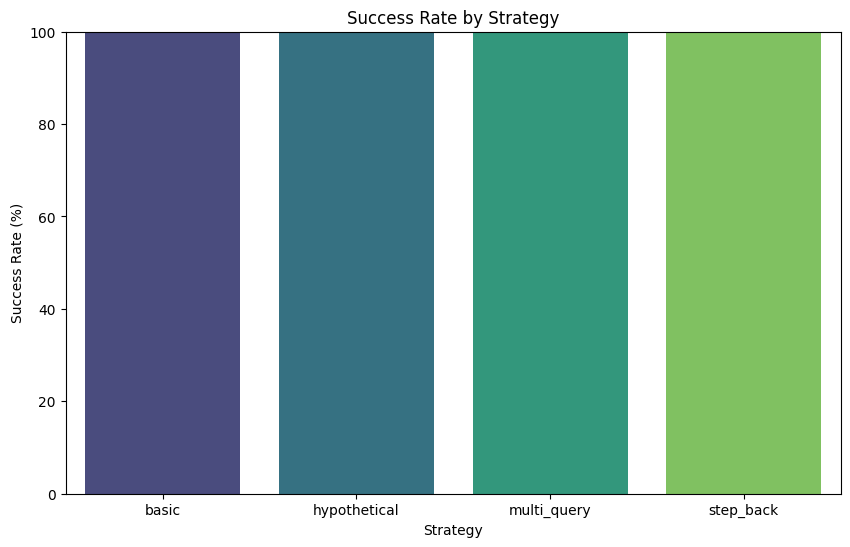

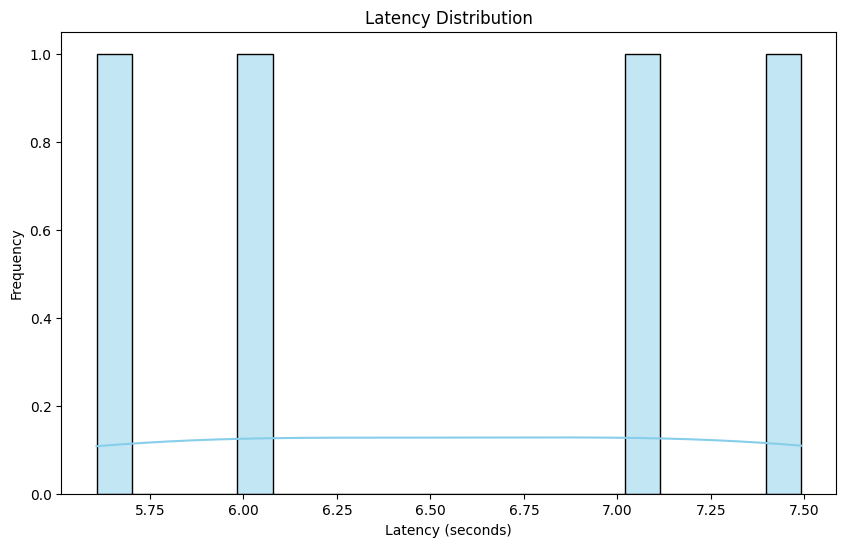

/var/folders/cz/b58fmnqd6tqdhlfztkvl9qt40000gn/T/ipykernel_17094/2327572093.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metrics_df, x='Strategy', y='Response Length', palette='Set2')


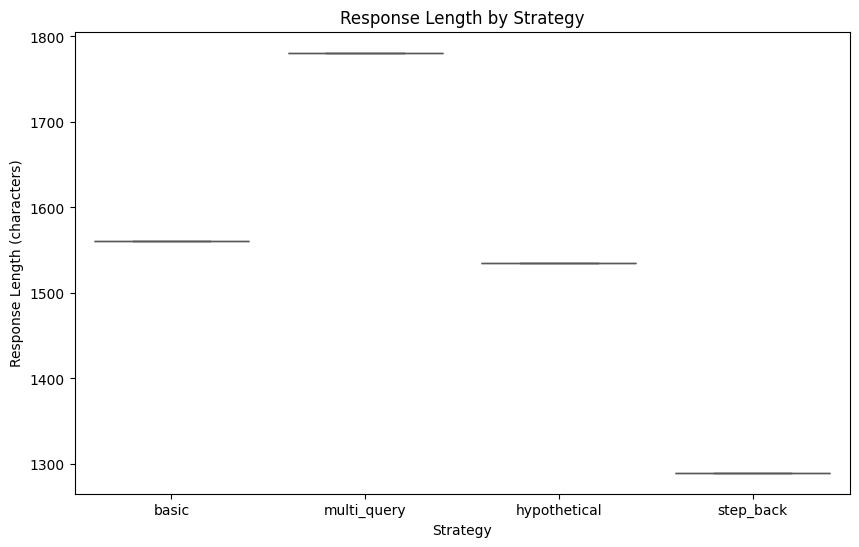

In [10]:
csv_files = glob.glob("results/rag_metrics_*.csv")
if csv_files:
    latest_csv = max(csv_files, key=lambda x: Path(x).stat().st_mtime)
    metrics_df = pd.read_csv(latest_csv)
    
    # Display basic metrics
    display(metrics_df.head())

    # Plot Success Rate by Strategy
    success_rates = metrics_df.groupby('Strategy')['Status'].apply(lambda x: (x == 'Success').mean() * 100).reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=success_rates, x='Strategy', y='Status', palette='viridis')
    plt.title('Success Rate by Strategy')
    plt.ylabel('Success Rate (%)')
    plt.xlabel('Strategy')
    plt.ylim(0, 100)
    plt.show()

    # Plot Latency Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(metrics_df['Latency (s)'], bins=20, kde=True, color='skyblue')
    plt.title('Latency Distribution')
    plt.xlabel('Latency (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    # Plot Response Length by Strategy
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metrics_df, x='Strategy', y='Response Length', palette='Set2')
    plt.title('Response Length by Strategy')
    plt.xlabel('Strategy')
    plt.ylabel('Response Length (characters)')
    plt.show()
    
else:
    print("No CSV metrics found in the 'results' directory.")

In [16]:
# Cell X: Analyze Specific Query Results with Enhanced Visualization

import pandas as pd
from IPython.display import display, Markdown

# Define the specific query
specific_query = "I need storage solutions for a small bathroom"

# Filter results for the specific query
specific_results = [
    result for result in rag_results["results"] 
    if result["execution_info"]["query"].lower() == specific_query.lower()
]

if specific_results:
    # Prepare data for DataFrame
    data = []
    for res in specific_results:
        retrieved_context = ', '.join([
            f"{doc['product_name']} (Item No: {doc.get('item_no', 'N/A')})" 
            for doc in res.get("retrieval_info", {}).get("retrieved_documents", [])
        ])
        prompt_used = res.get("response_info", {}).get("prompt_used", "N/A")
        response = res.get("response_info", {}).get("generated_response", "N/A")
        latency = res.get("execution_info", {}).get("latency", 0.0)
        
        data.append({
            "Strategy": res["execution_info"]["strategy"],
            "Response": response,
            "Latency (s)": latency,
            "Retrieved Context": retrieved_context,
            "Prompt Used": prompt_used
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Define styling functions
    def highlight_latency(val):
        """Highlight latency with colors: Green (<1s), Yellow (1-3s), Red (>3s)"""
        try:
            val = float(val)
            if val < 1:
                color = '#d4edda'  # Green
            elif val < 3:
                color = '#fff3cd'  # Yellow
            else:
                color = '#f8d7da'  # Red
            return f'background-color: {color}'
        except:
            return ''
    
    def highlight_status(val):
        """Highlight Success/Failed with colors"""
        if val.lower() == 'success':
            return 'background-color: #d4edda'  # Green
        elif val.lower() == 'failed':
            return 'background-color: #f8d7da'  # Red
        else:
            return ''
    
    # Apply styling
    styled_df = df.style.applymap(highlight_latency, subset=['Latency (s)']) \
                        .set_properties(**{
                            'text-align': 'left',
                            'padding': '8px'
                        }) \
                        .set_table_styles([
                            {'selector': 'th', 
                             'props': [('background-color', '#f2f2f2'), 
                                       ('color', 'black'), 
                                       ('text-align', 'left'),
                                       ('padding', '8px')]},
                            {'selector': 'td', 
                             'props': [('border', '1px solid #dddddd')]}
                        ]) \
                        .set_caption(f"### Analysis for Query: \"{specific_query}\"")
    
    # Display the styled DataFrame
    display(styled_df)
    
    # Optionally, display retrieved context and prompt separately for clarity
    for res in specific_results:
        strategy = res["execution_info"]["strategy"]
        response = res.get("response_info", {}).get("generated_response", "N/A")
        latency = res.get("execution_info", {}).get("latency", 0.0)
        retrieved_context = ', '.join([
            f"{doc['product_name']} (Item No: {doc.get('item_no', 'N/A')})" 
            for doc in res.get("retrieval_info", {}).get("retrieved_documents", [])
        ])
        prompt_used = res.get("response_info", {}).get("prompt_used", "N/A")
        
        print(f"### Strategy: {strategy}")
        print(f"**Response:** {response}")
        print(f"**Latency:** {latency:.3f}s")
        print(f"**Retrieved Context:** {retrieved_context}")
        print(f"**Prompt Used:** {prompt_used}")
        print("-" * 50)
else:
    display(Markdown(f"No results found for the query: **\"{specific_query}\"**"))


/var/folders/cz/b58fmnqd6tqdhlfztkvl9qt40000gn/T/ipykernel_17094/4146420131.py:63: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(highlight_latency, subset=['Latency (s)']) \


,Strategy,Response,Latency (s),Retrieved Context,Prompt Used
0,basic,"Product 1: ENHET (Item No: 99547652) Price: $484.99 Dimensions: 35.4"" x 23.6"" x 29.5"" (90 cm x 60 cm x 75 cm) This product is a great option for small bathrooms as it provides a compact and shallow wash-stand with open and closed storage, perfect for storing toiletries and towels. The mirror on the door adds an extra layer of functionality, allowing you to get ready in the morning while keeping your bathroom organized. Product 2: ENHET (Item No: 29546953) Price: $543.99 Dimensions: 35.4"" x 23.6"" x 29.5"" (90 cm x 60 cm x 75 cm) This product is similar to the first one, but with a slightly higher price point due to additional features such as a more premium finish or upgraded hardware. If you're looking for a more luxurious look without breaking the bank, this might be the better option. Product 3: ENHET (Item No: 69547074) Price: $431.99 Dimensions: 35.4"" x 23.6"" x 29.5"" (90 cm x 60 cm x 75 cm) This product offers the same functionality as the first two options but at a lower price point, making it an excellent value for those on a budget. Considering your need for storage solutions in a small bathroom, I recommend starting with Product 1 (ENHET Item No: 99547652) due to its balance of affordability and functionality. However, if you're willing to invest in a more premium product, Product 2 (ENHET Item No: 29546953) might be worth considering. If budget is your top priority, Product 3 (ENHET Item No: 69547074) is also an excellent option that still provides ample storage space without breaking the bank. End of recommendations",6.068803,"ENHET (Item No: 99547652), ENHET (Item No: 29546953), ENHET (Item No: 69547074)","<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert IKEA product advisor. Consider the full context of the customer's needs and provide detailed, complete recommendations. Never stop mid-explanation and always include comprehensive product details including measurements, prices, and specific benefits. Important: Always end your response with ""End of recommendations.""<|eot_id|> <|start_header_id|>user<|end_header_id|> Here is the product context and customer query: Product Context: Product: ENHET Item No: 99547652 Type: bathroom Price: $484.99 Benefits: Even the smallest bathroom can fit great storage when you combine a shallow wash-stand with open and closed storage. With a beautiful reflection on the mirror, every morning is a good morning. Score: 0.8287312984466553 Product: ENHET Item No: 29546953 Type: bathroom Price: $543.99 Benefits: Even the smallest bathroom can fit great storage when you combine a shallow wash-stand with open and closed storage. With a beautiful reflection on the mirror, every morning is a good morning. Score: 0.8287312984466553 Product: ENHET Item No: 69547074 Type: bathroom Price: $431.99 Benefits: Even the smallest bathroom can fit great storage when you combine a shallow wash-stand with open and closed storage. With a beautiful reflection on the mirror, every morning is a good morning. Score: 0.8287312984466553 Customer Query: I need storage solutions for a small bathroom<|eot_id|> <|start_header_id|>assistant<|end_header_id|> Let me help you find the perfect IKEA products for your needs. Based on the available products, here are my detailed recommendations:"
1,multi_query,"- For ""Bathroom storage units for compact spaces"", I recommend the following: Product: JONAXEL (Item No: 50419972) Type: shelf unit Price: $49.99 Benefits: This product is a great option for compact spaces as it's a shelf unit that can be used to store small items, and it's also easy to assemble and install. - For ""Alternative to traditional cabinets for small bathroom organization"", I recommend the following: Product: IVÖSJÖN (Item No: 10569096) Type: mirror cabinet with 1 door Price: $19.99 Benefits: This product offers a unique alternative to traditional cabinets by providing both open and closed storage,

### Strategy: basic
**Response:** 


Product 1: ENHET (Item No: 99547652)
Price: $484.99
Dimensions: 35.4" x 23.6" x 29.5" (90 cm x 60 cm x 75 cm)
This product is a great option for small bathrooms as it provides a compact and shallow wash-stand with open and closed storage, perfect for storing toiletries and towels. The mirror on the door adds an extra layer of functionality, allowing you to get ready in the morning while keeping your bathroom organized.


Product 2: ENHET (Item No: 29546953)
Price: $543.99
Dimensions: 35.4" x 23.6" x 29.5" (90 cm x 60 cm x 75 cm)
This product is similar to the first one, but with a slightly higher price point due to additional features such as a more premium finish or upgraded hardware. If you're looking for a more luxurious look without breaking the bank, this might be the better option.


Product 3: ENHET (Item No: 69547074)
Price: $431.99
Dimensions: 35.4" x 23.6" x 29.5" (90 cm x 60 cm x 75 cm)
This product offers the same functionality as the fi